# Modeling Process

In [23]:
# Utils.models contains all libraries needed
from utils.models import *
from utils.email_notification import *
import os
# to get notification via email. You need to configure settings_email.py
import settings_email as cfg

In [24]:
# notebook parameters

models_path = '../models'
data_path = '../data'
output_path = '../outputs'
filename_data = 'clean-dataset'

In [25]:
# load data
data = pd.read_csv(f"{data_path}/{filename_data}.csv")
print('This dataset has shape: ', data.shape)
data.head()

This dataset has shape:  (30000, 42)


,LIMIT_BAL,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,...,PAY_TO_BILL_5,PAY_TO_BILL_6,PAY_AMOUNT_STD_LAST_6M,BILL_AMOUNT_STD_LAST_6M,AGE_<=40,AGE_<=60,AGE_<=80,RISKY_GROUP1,RISKY_GROUP2,RISKY_GROUP3
0,20000,2,2,-1,-1,-2,-2,3913,3102,689,...,0.000000,0.000000,281.283072,1761.633219,1,0,0,1,0,1
1,120000,-1,2,0,0,0,2,2682,1725,2682,...,0.000000,0.613121,752.772653,637.967841,1,0,0,1,0,1
2,90000,0,0,0,0,0,0,29239,14027,13559,...,0.066894,0.321543,1569.815488,6064.518593,1,0,0,1,0,1
3,50000,0,0,0,0,0,0,46990,48233,49291,...,0.036913,0.033843,478.058155,10565.793518,1,0,0,1,0,1
4,50000,-1,0,-1,0,0,0,8617,5670,35835,...,0.035985,0.035490,13786.230736,10668.590074,0,1,0,0,1,0


In [26]:
# pre processing data and scaling
X, y = preprocess(data, 'dpnm', scaler=False)

In [27]:
# init models

tree = DecisionTreeClassifier()
sgd = SGDClassifier(loss='log')
lr = LogisticRegression(solver = 'lbfgs')
svc = LinearSVC()
rf = RandomForestClassifier()
xgboost = xgb.XGBClassifier()
naive = GaussianNB()
knn = KNeighborsClassifier()
ada = AdaBoostClassifier()

***
### Training Models

#### Apply SMOTE to get a balanced dataset

In [28]:
# Apply resampling method to training data
resample = BorderlineSMOTE()
X_resampled, y_resampled = resample.fit_resample(X, y)

print('Dimension of training set before resampling: ', X.shape)
print('Dimension of training set after resampling: ', X_resampled.shape)

Dimension of training set before resampling:  (29933, 41)
Dimension of training set after resampling:  (46612, 41)


In [29]:
# Split your data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=123)

In [32]:
# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers',
                                     'auc',
                                     'best_params',
                                     'best_score',
                                     'n_features'])

In [33]:
classifiers = [
    {"Model":rf,
        "params":{'max_depth': [7,8],
                  'max_features': [7,8],
                  'n_estimators': [60,70]}},
    {"Model":knn,
        "params":{"n_neighbors":[2,3,4,5],
                  'algorithm':['auto', 'ball_tree']}},
    {"Model":xgboost,
        "params":{'max_depth': [7,11],
                  'learning_rate':[0.2,0.5],
                  'eval_metric':['mlogloss']}},
    {"Model":ada,
        "params":{'n_estimators':[60,70],
                  'learning_rate':[0.05, 0.01, 0.1]}},
    {"Model":svc,
        "params":{'C':[0.01,0.05, 0.1]}},
    {"Model":lr,
        "params":{'penalty':['l2'],
                  'C':[100,10,1,0.1]}}
]

### Traning models with features selected

100%|██████████| 6/6 [05:26<00:00, 54.44s/it] 


Training RandomForestClassifier-v4:
This model uses 27 features
F1 score in training is: 0.8457575407736633
Best params in training are: {'max_depth': 8, 'max_features': 8, 'n_estimators': 60}
Classifier in testing:  RandomForestClassifier
              precision    recall  f1-score   support

  No Default       0.81      0.91      0.86      6955
     Default       0.90      0.80      0.84      7029

    accuracy                           0.85     13984
   macro avg       0.86      0.85      0.85     13984
weighted avg       0.86      0.85      0.85     13984

Model RandomForestClassifier-v4.pkl saved successfully
ROC Curve of model RandomForestClassifier-v4.png saved successfully
---------------------------------------------------------


Training KNeighborsClassifier-v4:
This model uses 28 features
F1 score in training is: 0.7626228391725259
Best params in training are: {'algorithm': 'ball_tree', 'n_neighbors': 3}
Classifier in testing:  KNeighborsClassifier
              precision  

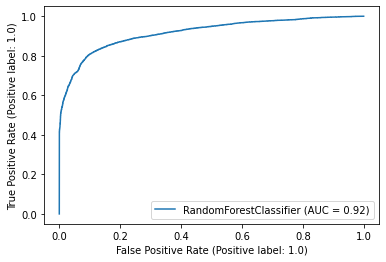

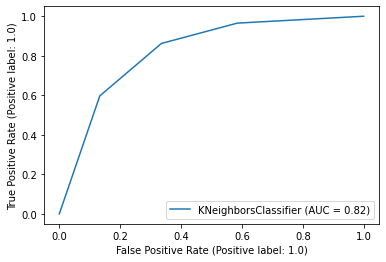

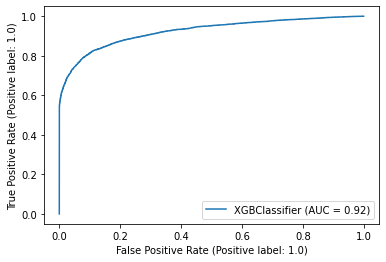

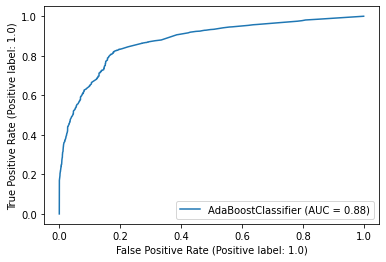

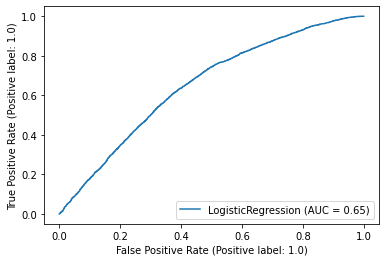

In [34]:
version = 'v4'
features_path = '../models/features_by_models'
for clf in tqdm(classifiers):
    try:
        estimator = clf['Model']
        param_grid = clf['params']
        name_model = estimator.__class__.__name__
        # get features names for model
        columns = get_columns_model(name_model, features_path)
        # use best features for models
        X_train_filtered = X_train[columns]
        X_test_filtered = X_test[columns]
        # training process
        fpr, tpr, auc, best_params, best_score = train_model(estimator,
                                                             param_grid,
                                                             X_train_filtered,
                                                             y_train,
                                                             X_test_filtered,
                                                             y_test,
                                                             models_path,
                                                             output_path,
                                                             version)

        result_table = result_table.append({
            'classifiers': f"{name_model}-{version}",
            'auc': auc,
            'best_params': best_params,
            'best_score': best_score,
            'n_features': X_train_filtered.shape[1]},ignore_index=True)
    except:
        send_email(cfg.to_send, f"Something went wrong", f"Unable to train model {name_model}-{version}")
        pass

try:
    send_email(cfg.to_send, f"Training {version}", f"Training of models {version} completed!")
except:
    pass

### Training Models with All Features

100%|██████████| 6/6 [07:13<00:00, 72.18s/it] 


Training RandomForestClassifier-v5:
This model uses 41 features
F1 score in training is: 0.8367936443380399
Best params in training are: {'max_depth': 8, 'max_features': 7, 'n_estimators': 70}
Classifier in testing:  RandomForestClassifier
              precision    recall  f1-score   support

  No Default       0.81      0.89      0.85      6955
     Default       0.88      0.80      0.84      7029

    accuracy                           0.84     13984
   macro avg       0.85      0.84      0.84     13984
weighted avg       0.85      0.84      0.84     13984

Model RandomForestClassifier-v5.pkl saved successfully
ROC Curve of model RandomForestClassifier-v5.png saved successfully
---------------------------------------------------------


Training KNeighborsClassifier-v5:
This model uses 41 features
F1 score in training is: 0.7835181668046635
Best params in training are: {'algorithm': 'ball_tree', 'n_neighbors': 3}
Classifier in testing:  KNeighborsClassifier
              precision  

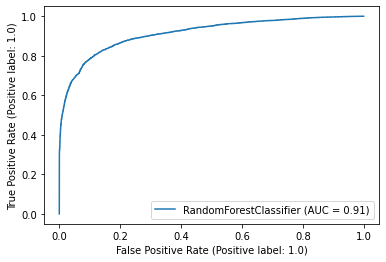

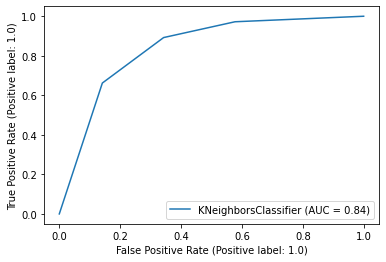

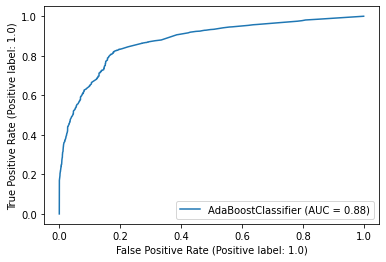

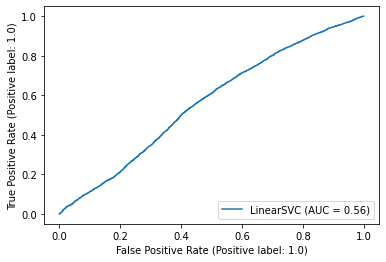

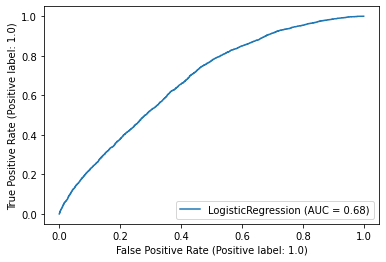

In [35]:
version = 'v5'
for clf in tqdm(classifiers):
    try:
        estimator = clf['Model']
        param_grid = clf['params']
        name_model = estimator.__class__.__name__
        # training process
        fpr, tpr, auc, best_params, best_score = train_model(estimator,
                                                             param_grid,
                                                             X_train,
                                                             y_train,
                                                             X_test,
                                                             y_test,
                                                             models_path,
                                                             output_path,
                                                             version)

        result_table = result_table.append({
            'classifiers': f"{name_model}-{version}",
            'auc': auc,
            'best_params': best_params,
            'best_score': best_score,
            'n_features': X_train.shape[1]},ignore_index=True)

    except:
        send_email(cfg.to_send, f"Something went wrong", f"Unable to train model {name_model}-{version}")
        pass
try:
    send_email(cfg.to_send, f"Training {version}", f"Training of models {version} completed!")
except:
    pass

***

In [36]:
result_table.to_excel(f"{output_path}/comparison-models2.xlsx", index=False)
result_table

,classifiers,auc,best_params,best_score,n_features
0,RandomForestClassifier-v4,0.917585,"{'max_depth': 8, 'max_features': 8, 'n_estimat...",0.845758,27
1,KNeighborsClassifier-v4,0.823219,"{'algorithm': 'ball_tree', 'n_neighbors': 3}",0.762623,28
2,XGBClassifier-v4,0.923320,"{'eval_metric': 'mlogloss', 'learning_rate': 0...",0.848832,17
3,AdaBoostClassifier-v4,0.876341,"{'learning_rate': 0.1, 'n_estimators': 70}",0.776575,27
4,LogisticRegression-v4,0.651304,"{'C': 100, 'penalty': 'l2'}",0.151039,17
5,RandomForestClassifier-v5,0.914359,"{'max_depth': 8, 'max_features': 7, 'n_estimat...",0.836794,41
6,KNeighborsClassifier-v5,0.838681,"{'algorithm': 'ball_tree', 'n_neighbors': 3}",0.783518,41
7,AdaBoostClassifier-v5,0.876341,"{'learning_rate': 0.1, 'n_estimators': 70}",0.776575,41
8,LinearSVC-v5,0.000000,{'C': 0.1},0.480493,41
9,LogisticRegression-v5,0.679079,"{'C': 0.1, 'penalty': 'l2'}",0.472503,41


***

### Removing outliers

In [14]:
import scipy.stats as stats

In [15]:

# removing outlier
new_df = data[(data['PAY_0']<=2) &
              (data['PAY_2']<=2) &
              (data['PAY_3']<=2) &
              (data['PAY_4']<=2) &
              (data['PAY_5']<=2) &
              (data['PAY_6']<=2) &
              (data['LIMIT_BAL']<=600000)]

print('This new dataset has shape: ', new_df.shape)

This new dataset has shape:  (28695, 42)


In [16]:
# pre processing data and scaling
X, y = preprocess(new_df, 'dpnm', scaler=True)

In [17]:
# Split your data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [18]:
# Apply resampling method to training data
resample = BorderlineSMOTE()
X_train_resampled, y_train_resampled = resample.fit_resample(X_train, y_train)

print('Dimension of training set before resampling: ', X_train.shape)
print('Dimension of training set after resampling: ', X_train_resampled.shape)

Dimension of training set before resampling:  (20062, 41)
Dimension of training set after resampling:  (31960, 41)


100%|██████████| 6/6 [09:27<00:00, 94.58s/it] 


Training RandomForestClassifier-v3:
This model uses 41 features
F1 score in training is: 0.7230689181554989
Best params in training are: {'max_depth': 8, 'max_features': 8, 'n_estimators': 70}
Classifier in testing:  RandomForestClassifier
              precision    recall  f1-score   support

  No Default       0.88      0.75      0.81      6810
     Default       0.40      0.62      0.48      1789

    accuracy                           0.72      8599
   macro avg       0.64      0.69      0.65      8599
weighted avg       0.78      0.72      0.74      8599

Model RandomForestClassifier-v3.pkl saved successfully
ROC Curve of model RandomForestClassifier-v3.png saved successfully
---------------------------------------------------------


Training KNeighborsClassifier-v3:
This model uses 41 features
F1 score in training is: 0.8292738841284855
Best params in training are: {'algorithm': 'ball_tree', 'n_neighbors': 2}
Classifier in testing:  KNeighborsClassifier
              precision  

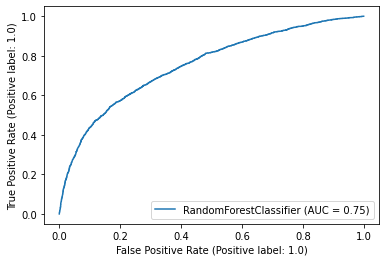

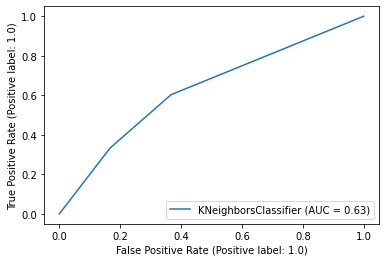

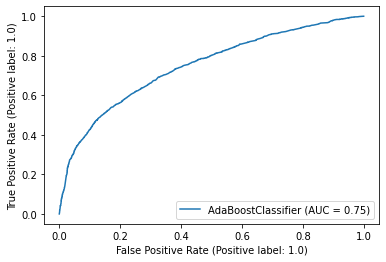

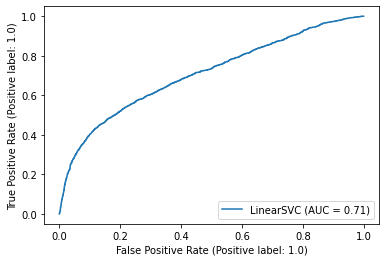

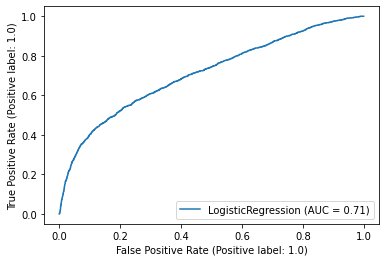

In [19]:
version = 'v3' # not outliers
for clf in tqdm(classifiers):
    try:
        estimator = clf['Model']
        param_grid = clf['params']
        name_model = estimator.__class__.__name__
        # training process
        fpr, tpr, auc, best_params, best_score = train_model(estimator,
                                                             param_grid,
                                                             X_train_resampled,
                                                             y_train_resampled,
                                                             X_test,
                                                             y_test,
                                                             models_path,
                                                             output_path,
                                                             version)

        result_table = result_table.append({
            'classifiers': f"{name_model}-{version}",
            'auc': auc,
            'best_params': best_params,
            'best_score': best_score,
            'n_features': X_train_resampled.shape[1]},ignore_index=True)

    except:
        send_email(cfg.to_send, f"Something went wrong", f"Unable to train model {name_model}-{version}")
        pass
try:
    send_email(cfg.to_send, f"Training {version}", f"Training of models {version} completed!")
except:
    pass

In [20]:
result_table.to_excel(f"{output_path}/comparison-models.xlsx", index=False)
result_table

,classifiers,auc,best_params,best_score,n_features
0,RandomForestClassifier-v1,0.770584,"{'max_depth': 8, 'max_features': 8, 'n_estimat...",0.814920,27
1,KNeighborsClassifier-v1,0.578219,"{'algorithm': 'ball_tree', 'n_neighbors': 2}",0.797994,28
2,XGBClassifier-v1,0.754205,"{'eval_metric': 'mlogloss', 'learning_rate': 0...",0.808241,17
3,AdaBoostClassifier-v1,0.740427,"{'learning_rate': 0.1, 'n_estimators': 70}",0.767315,27
4,LogisticRegression-v1,0.628619,"{'C': 10, 'penalty': 'l2'}",0.282700,17
5,RandomForestClassifier-v2,0.771680,"{'max_depth': 8, 'max_features': 8, 'n_estimat...",0.810274,41
6,KNeighborsClassifier-v2,0.568101,"{'algorithm': 'auto', 'n_neighbors': 2}",0.824032,41
7,AdaBoostClassifier-v2,0.740427,"{'learning_rate': 0.1, 'n_estimators': 70}",0.767315,41
8,LinearSVC-v2,0.000000,{'C': 0.05},0.589248,41
9,LogisticRegression-v2,0.646115,"{'C': 0.1, 'penalty': 'l2'}",0.495723,41


In [21]:
send_email(cfg.to_send, f"All done", f"Training is completed")

In [22]:
print('All done :)')

All done :)


***

